# Job Placement Dataset

In [2]:
# import packages
import keras
from keras.callbacks import EarlyStopping
from keras import layers
from keras.layers import Conv2D, Flatten, Dense, Dropout
from keras import models
from keras.regularizers import l2
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import random
import researchpy as rp
import scipy.stats as stats
import sklearn
from sklearn import compose
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn import discriminant_analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
from sklearn.svm import SVC
import tensorflow as tf

## Data Exploration

Data for this analysis were sourced from Kaggle (https://www.kaggle.com/datasets/ahsan81/job-placement-dataset). The objective of this analysis is to predict job placement status using various attributes of candidate's educational and professional history. The data dictionary supplied by the original poster is given below:

**Data Dictionary**  
gender : Gender of the candidate  
ssc_percentage : Senior secondary exams percentage (10th Grade)  
ssc_board : Board of education for ssc exams  
hsc_percentage : Higher secondary exams percentage (12th Grade)  
hsc_borad : Board of education for hsc exams  
hsc_subject : Subject of study for hsc  
degree_percentage : Percentage of marks in undergrad degree  
undergrad_degree : Undergrad degree majors  
work_experience : Past work experience  
emp_test_percentage : Aptitude test percentage  
specialization : Postgrad degree majors - (MBA specialization)  
mba_percent : Percentage of marks in MBA degree  
status (TARGET) : Status of placement. Placed / Not Placed

In [3]:
# read data from .csv file
data = pd.read_csv('Job_Placement_Data.csv')

# peek at data
display(data.head())

# check data set dimensions
display(data.shape)

,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent,status
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed


(215, 13)

In [4]:
# check data types
display(data.info())

# check for missing values
display(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               215 non-null    object 
 1   ssc_percentage       215 non-null    float64
 2   ssc_board            215 non-null    object 
 3   hsc_percentage       215 non-null    float64
 4   hsc_board            215 non-null    object 
 5   hsc_subject          215 non-null    object 
 6   degree_percentage    215 non-null    float64
 7   undergrad_degree     215 non-null    object 
 8   work_experience      215 non-null    object 
 9   emp_test_percentage  215 non-null    float64
 10  specialisation       215 non-null    object 
 11  mba_percent          215 non-null    float64
 12  status               215 non-null    object 
dtypes: float64(5), object(8)
memory usage: 22.0+ KB


None

gender                 0
ssc_percentage         0
ssc_board              0
hsc_percentage         0
hsc_board              0
hsc_subject            0
degree_percentage      0
undergrad_degree       0
work_experience        0
emp_test_percentage    0
specialisation         0
mba_percent            0
status                 0
dtype: int64

In [5]:
# calculate job placement rate
display(data['status'].value_counts())
print(f"Placement Rate: {np.mean(data['status'] == 'Placed').round(3)}")

Placed        148
Not Placed     67
Name: status, dtype: int64

Placement Rate: 0.688


### Numeric Predictors

A brief analysis of the numeric predictors in the dataset using visualizations and likelihood ratio tests concluded that *ssc_percentage*, *hsc_percentage*, and *degree_percentage* should likely be included in the final model. Additionally, there was some evidence to suggest that *emp_test_percentage* is associated with placement status so it will be included in future models as well

In [7]:
# summarize numeric predictors
data.describe()

,ssc_percentage,hsc_percentage,degree_percentage,emp_test_percentage,mba_percent
count,215.000000,215.000000,215.000000,215.000000,215.000000
mean,67.303395,66.333163,66.370186,72.100558,62.278186
std,10.827205,10.897509,7.358743,13.275956,5.833385
min,40.890000,37.000000,50.000000,50.000000,51.210000
25%,60.600000,60.900000,61.000000,60.000000,57.945000
50%,67.000000,65.000000,66.000000,71.000000,62.000000
75%,75.700000,73.000000,72.000000,83.500000,66.255000
max,89.400000,97.700000,91.000000,98.000000,77.890000


In [35]:
# likelihood ratio test function from http://rnowling.github.io/machine/learning/2017/10/07/likelihood-ratio-test.html
def likelihood_ratio_test(features_alternate, labels, lr_model, features_null=None):
    """
    Compute the likelihood ratio test for a model trained on the set of features in
    `features_alternate` vs a null model.  If `features_null` is not defined, then
    the null model simply uses the intercept (class probabilities).  Note that
    `features_null` must be a subset of `features_alternative` -- it can not contain
    features that are not in `features_alternate`.
    Returns the p-value, which can be used to accept or reject the null hypothesis.
    """
    labels = np.array(labels)
    features_alternate = np.array(features_alternate)
    
    if features_null:
        features_null = np.array(features_null)
        
        if features_null.shape[1] >= features_alternate.shape[1]:
            raise (ValueError, "Alternate features must have more features than null features")
        
        lr_model.fit(features_null, labels)
        null_prob = lr_model.predict_proba(features_null)[:, 1]
        df = features_alternate.shape[1] - features_null.shape[1]
    else:
        null_prob = sum(labels) / float(labels.shape[0]) * \
                    np.ones(labels.shape)
        df = features_alternate.shape[1]
    
    lr_model.fit(features_alternate, labels)
    alt_prob = lr_model.predict_proba(features_alternate)

    alt_log_likelihood = -sklearn.metrics.log_loss(labels,
                                   alt_prob,
                                   normalize=False)
    null_log_likelihood = -sklearn.metrics.log_loss(labels,
                                    null_prob,
                                    normalize=False)

    G = 2 * (alt_log_likelihood - null_log_likelihood)
    p_value = stats.chi2.sf(G, df)

    return p_value

In [36]:
# boxplot factored by status
px.box(x = data['status'], 
       y = data['ssc_percentage'],
       labels = {
            'x': 'Placement Status',
            'y': 'SSC Percentage'
       },
       title = 'SSC Percentage Comparison').show()

# fit logistic regression model on single predictor
logFit = LogisticRegression().fit(np.array(data['ssc_percentage']).reshape(-1, 1), 
                                  data['status'])

# perform likelihood ratio test for independence
lrtPval = likelihood_ratio_test(np.array(data['ssc_percentage']).reshape(-1, 1), 
                                (data['status'] == 'Placed').astype(int), 
                                logFit)
print(f"LRT p-value: {lrtPval}")

LRT p-value: 8.939383353715161e-23


In [791]:
# boxplot factored by status
px.box(x = data['status'], 
       y = data['hsc_percentage'],
       labels = {
            'x': 'Placement Status',
            'y': 'HSC Percentage'
       },
       title = 'HSC Percentage Comparison').show()

# fit logistic regression model on single predictor
logFit = LogisticRegression().fit(np.array(data['hsc_percentage']).reshape(-1, 1), 
                                  data['status'])

# perform likelihood ratio test for independence
lrtPval = likelihood_ratio_test(np.array(data['hsc_percentage']).reshape(-1, 1), 
                                (data['status'] == 'Placed').astype(int), 
                                logFit)
print(f"LRT p-value: {lrtPval}")

LRT p-value: 2.2508006047868448e-15


In [792]:
# boxplot factored by status
px.box(x = data['status'], 
       y = data['degree_percentage'],
       labels = {
            'x': 'Placement Status',
            'y': 'Degree Percentage'
       },
       title = 'Degree Percentage Comparison').show()

# fit logistic regression model on single predictor
logFit = LogisticRegression().fit(np.array(data['degree_percentage']).reshape(-1, 1), 
                                  data['status'])

# perform likelihood ratio test for independence
lrtPval = likelihood_ratio_test(np.array(data['degree_percentage']).reshape(-1, 1), 
                                (data['status'] == 'Placed').astype(int), 
                                logFit)
print(f"LRT p-value: {lrtPval}")

LRT p-value: 2.044428524054884e-14


In [793]:
# boxplot factored by status
px.box(x = data['status'], 
       y = data['emp_test_percentage'],
       labels = {
            'x': 'Placement Status',
            'y': 'EMP Test Percentage'
       },
       title = 'EMP Test Percentage Comparison').show()

# fit logistic regression model on single predictor
logFit = LogisticRegression().fit(np.array(data['emp_test_percentage']).reshape(-1, 1), 
                                  data['status'])

# perform likelihood ratio test for independence
lrtPval = likelihood_ratio_test(np.array(data['emp_test_percentage']).reshape(-1, 1), 
                                (data['status'] == 'Placed').astype(int), 
                                logFit)
print(f"LRT p-value: {lrtPval}")

LRT p-value: 0.05918182852278074


In [794]:
# boxplot factored by status
px.box(x = data['status'], 
       y = data['mba_percent'],
       labels = {
            'x': 'Placement Status',
            'y': 'MBA Percentage'
       },
       title = 'MBA Percentage Comparison').show()

# fit logistic regression model on single predictor
logFit = LogisticRegression().fit(np.array(data['mba_percent']).reshape(-1, 1), 
                                  data['status'])

# perform likelihood ratio test for independence
lrtPval = likelihood_ratio_test(np.array(data['mba_percent']).reshape(-1, 1), 
                                (data['status'] == 'Placed').astype(int), 
                                logFit)
print(f"LRT p-value: {lrtPval}")

LRT p-value: 0.257167121513069


### Categorical Predictors

A brief analysis of the categorical predictors in the dataset using contingency tables and chi-squared independence tests concluded that *work_experience* and *specialisation* should likely be included in the final model. Additionally, there was some evidence to suggest that *gender* is associated with placement status so it will be included in future models as well since gender discrimination in hiring practices is a known and studied phenomenon. 

In [795]:
# sumamrize categorical predictors
findCatPredictors = make_column_selector(dtype_include = object)
rp.summary_cat(data[findCatPredictors(data)[0:(len(findCatPredictors(data)) - 1)]])

,Variable,Outcome,Count,Percent
0,gender,M,139,64.65
1,,F,76,35.35
2,ssc_board,Central,116,53.95
3,,Others,99,46.05
4,hsc_board,Others,131,60.93
5,,Central,84,39.07
6,hsc_subject,Commerce,113,52.56
7,,Science,91,42.33
8,,Arts,11,5.12
9,undergrad_degree,Comm&Mgmt,145,67.44


In [796]:
# construct contingency table
contingency = pd.crosstab(data['status'], data['gender'])
display(contingency)

# perform chi-squared test for independence
print(f"Chi-squared test p-value: {stats.chi2_contingency(contingency)[1]}")

gender,F,M
status,,
Not Placed,28,39
Placed,48,100


Chi-squared test p-value: 0.23980260881037568


In [797]:
# construct contingency table
contingency = pd.crosstab(data['status'], data['ssc_board'])
display(contingency)

# perform chi-squared test for independence``
print(f"Chi-squared test p-value: {stats.chi2_contingency(contingency)[1]}")

ssc_board,Central,Others
status,,
Not Placed,38,29
Placed,78,70


Chi-squared test p-value: 0.6897729431530739


In [798]:
# construct contingency table
contingency = pd.crosstab(data['status'], data['hsc_board'])
display(contingency)

# perform chi-squared test for independence
print(f"Chi-squared test p-value: {stats.chi2_contingency(contingency)[1]}")

hsc_board,Central,Others
status,,
Not Placed,27,40
Placed,57,91


Chi-squared test p-value: 0.9222837052885


In [799]:
# construct contingency table
contingency = pd.crosstab(data['status'], data['hsc_subject'])
display(contingency)

# perform chi-squared test for independence
print(f"Chi-squared test p-value: {stats.chi2_contingency(contingency)[1]}")

hsc_subject,Arts,Commerce,Science
status,,,
Not Placed,5,34,28
Placed,6,79,63


Chi-squared test p-value: 0.5727118511343621


In [800]:
# construct contingency table
contingency = pd.crosstab(data['status'], data['undergrad_degree'])
display(contingency)

# perform chi-squared test for independence
print(f"Chi-squared test p-value: {stats.chi2_contingency(contingency)[1]}")

undergrad_degree,Comm&Mgmt,Others,Sci&Tech
status,,,
Not Placed,43,6,18
Placed,102,5,41


Chi-squared test p-value: 0.22661076190356658


In [801]:
# construct contingency table
contingency = pd.crosstab(data['status'], data['work_experience'])
display(contingency)

# perform chi-squared test for independence
print(f"Chi-squared test p-value: {stats.chi2_contingency(contingency)[1]}")

work_experience,No,Yes
status,,
Not Placed,57,10
Placed,84,64


Chi-squared test p-value: 9.906584720516494e-05


In [802]:
# construct contingency table
contingency = pd.crosstab(data['status'], data['specialisation'])
display(contingency)

# perform chi-squared test for independence
print(f"Chi-squared test p-value: {stats.chi2_contingency(contingency)[1]}")

specialisation,Mkt&Fin,Mkt&HR
status,,
Not Placed,25,42
Placed,95,53


Chi-squared test p-value: 0.00042018425858864284


## Model Fitting

In [6]:
# scale numeric predictors and encode categorical predictors
findNumPredictors = make_column_selector(dtype_include = float)
findCatPredictors = make_column_selector(dtype_include = object)
transform = make_column_transformer((StandardScaler(),
                                     findNumPredictors),
                                    (OneHotEncoder(drop = 'first'),
                                     findCatPredictors))

# get new column names
colNames = transform.fit(data.drop('status',
                                   axis = 1)).get_feature_names_out()

# transform data
modelDF = pd.DataFrame(transform.fit_transform(data.drop('status', 
                                                         axis = 1)),
                                                         columns = colNames)

np.random.seed(3172023) # set random seed

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(modelDF,
                                                    data['status'],
                                                    test_size = 0.2)

# rename predictor dataframes
X_train = pd.DataFrame(X_train,
                       columns = colNames)
X_test = pd.DataFrame(X_test,
                      columns = colNames)

# set of selected features
features = ['standardscaler__ssc_percentage',
            'standardscaler__hsc_percentage',
            'standardscaler__degree_percentage',
            'standardscaler__emp_test_percentage',
            'onehotencoder__gender_M',
            'onehotencoder__work_experience_Yes',
            'onehotencoder__specialisation_Mkt&HR']

A logistic regression model was fit using the selected predictors and achieved a cross-validation accuracy of 89%

In [804]:
np.random.seed(3172023) # set random seed

logFit = LogisticRegression()
cvResults = cross_val_score(logFit, 
                            X_train[features], 
                            y_train, 
                            cv = 10)

print(f"Cross-validation accuracy: {np.mean(cvResults).round(4)}")

Cross-validation accuracy: 0.8899


A linear discriminant analysis model slightly underperformed the logistic regression model with a cross-validation accuracy of 88.4%.

In [805]:
np.random.seed(3172023) # set random seed

ldaFit = LinearDiscriminantAnalysis()
cvResults = cross_val_score(ldaFit, 
                            X_train[features], 
                            y_train, 
                            cv = 10)

print(f"Cross-validation accuracy: {np.mean(cvResults).round(4)}")

Cross-validation accuracy: 0.884


A K-Nearest Neighbors model performed still worse with a cross-validation accuracy of 86%.

In [806]:
np.random.seed(3172023) # set random seed

# tune KNN model
Kvalues = range(1, 20)
knnFit = KNeighborsClassifier()
knnTune = GridSearchCV(knnFit,
                       param_grid = {'n_neighbors': Kvalues},
                       cv = 10)
knnTune.fit(X_train[features],
            y_train)
cvResults = knnTune.cv_results_['mean_test_score']
K = knnTune.best_params_['n_neighbors']

np.random.seed(3172023) # set random seed

# fit KNN model
knnFit = KNeighborsClassifier(n_neighbors = K)
cvResults = cross_val_score(knnFit,
                            X_train[features],
                            y_train,
                            cv = 10)

print(f"Cross-validation accuracy: {np.mean(cvResults).round(4)}")

Cross-validation accuracy: 0.8598


A random forest model was also found to be competitive with a cross-validation accuracy of 87.8%.

In [807]:
np.random.seed(3182023) # set random seed

# tune random forest model
Mvalues = range(1, len(X_train.columns))
rfFit = RandomForestClassifier()
rfTune = GridSearchCV(rfFit,
                      param_grid = {'max_features': Mvalues},
                      cv = 10)
rfTune.fit(X_train,
           y_train)
M = rfTune.best_params_['max_features']

np.random.seed(3182023) # set random seed

# fit random forest model
rfFit = RandomForestClassifier(max_features = M)
cvResults = cross_val_score(rfFit,
                            X_train,
                            y_train,
                            cv = 10)

print(f"Cross-validation accuracy: {np.mean(cvResults).round(4)}")

Cross-validation accuracy: 0.8778


An AdaBoost model performed comparably to the above random forest model with a cross-validation accuracy of 87.2%.

In [808]:
np.random.seed(3182023) # set random seed

# tune adaboost model
Bvalues = [10, 25, 50, 75, 100, 500]
Lvalues = [.001, .01, .1, .25, .5, 1]
adaFit = AdaBoostClassifier()
adaTune = GridSearchCV(adaFit,
                       param_grid = {'n_estimators': Bvalues,
                                     'learning_rate': Lvalues},
                       cv = 10)
adaTune.fit(X_train,
            y_train)
B = adaTune.best_params_['n_estimators']
L = adaTune.best_params_['learning_rate']

np.random.seed(3182023) # set random seed

# fit adaboost model
adaFit = AdaBoostClassifier(n_estimators = B,
                            learning_rate = L)
cvResults = cross_val_score(adaFit,
                            X_train,
                            y_train,
                            cv = 10)

print(f"Cross-validation accuracy: {np.mean(cvResults).round(4)}")

Cross-validation accuracy: 0.8722


A support vector machine model matched the logistic regression with a cross-validation accuracy of 89%. 

In [809]:
np.random.seed(3182023) # set random seed

# tune svm model
Cvalues = [.1, .25, .5, .75, 1, 2, 5, 10, 25, 50, 100]
Kernels = ['linear', 'poly', 'rbf']
svmFit = SVC()
svmTune = GridSearchCV(svmFit,
                       param_grid = {'C': Cvalues,
                                     'kernel': Kernels},
                       cv = 10)
svmTune.fit(X_train[features],
            y_train)
C = svmTune.best_params_['C']
Kernel = svmTune.best_params_['kernel']

np.random.seed(3182023) # set random seed

# fit svm model
svmFit = SVC(C = C,
             kernel = Kernel)
cvResults = cross_val_score(svmFit,
                            X_train[features],
                            y_train,
                            cv = 10)

print(f"Cross-validation accuracy: {np.mean(cvResults).round(4)}")

Cross-validation accuracy: 0.8895


Logistic regression, random forest, and support vector machine models were chosen for final testing against a held-out test set. The random forest classifier performed the best with a test accuracy of 88.4%.

In [810]:
# fit logistic regression model
logFit = LogisticRegression().fit(X_train[features],
                                  y_train)
logPred = logFit.predict(X_test[features])
print(f"Logistic regression test accuracy: {accuracy_score(y_test, logPred).round(4)}")

# fit random forest model
rfFit = RandomForestClassifier(max_features = M).fit(X_train,
                                                     y_train)
rfPred = rfFit.predict(X_test)
print(f"Random forest test accuracy: {accuracy_score(y_test, rfPred).round(4)}")

# fit svm model
svmFit = SVC(C = C,
             kernel = Kernel).fit(X_train,
                                  y_train)
svmPred = svmFit.predict(X_test)
print(f"Support vector machine test accuracy: {accuracy_score(y_test, svmPred).round(4)}")

Logistic regression test accuracy: 0.8605
Random forest test accuracy: 0.8837
Support vector machine test accuracy: 0.8605


A basic perceptron model with three hidden layers was fit using an early stopping and penalized regularization. This model achieved a validation accuracy of 88.57% and a test accuracy of 88.37%.

Epoch 38: early stopping


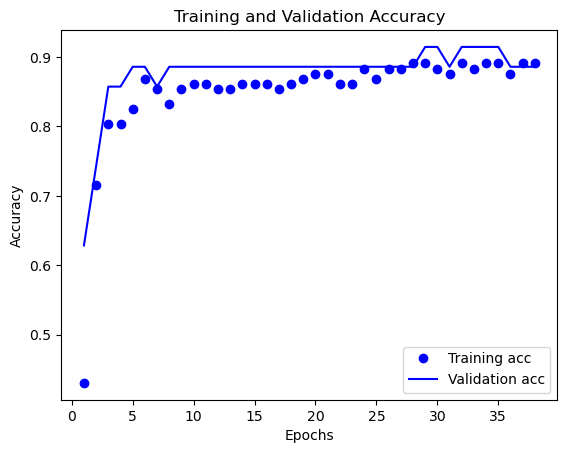

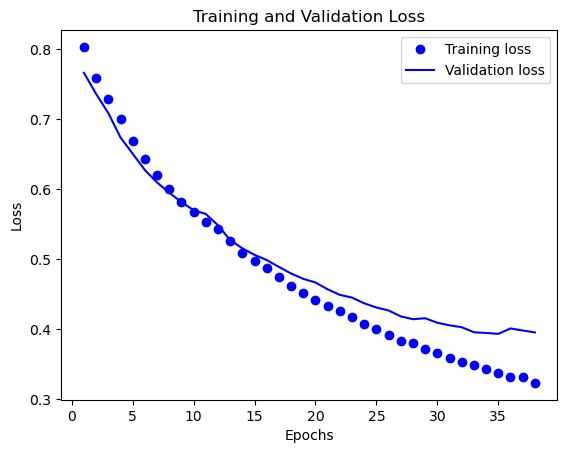

2/2 - 0s - loss: 0.4071 - accuracy: 0.8837 - 91ms/epoch - 45ms/step
Normalizing penalty test accuracy: 88.37%


In [16]:
# set random seeds
np.random.seed(462023)
tf.random.set_seed(4112023)

# penalty hyperparameter
PENALTY = 0.001

# define model architecture
model = models.Sequential([
    Dense(72, activation = 'relu', kernel_regularizer = l2(PENALTY), input_shape = (X_train.shape[1], )),
    Dense(36, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(18, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(2, activation = 'sigmoid')
])

# compile model
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# prepare response vectors
enc = OneHotEncoder()
y_trainDL = pd.DataFrame.sparse.from_spmatrix(enc.fit_transform(np.array(y_train).reshape(-1, 1)))
y_testDL = pd.DataFrame.sparse.from_spmatrix(enc.fit_transform(np.array(y_test).reshape(-1, 1)))

# number of epochs
EPOCHS = 50

# early stiopping criterion
early = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)

# train model
trained = model.fit(X_train, 
                    y_trainDL, 
                    epochs = EPOCHS, 
                    batch_size = 128,
                    validation_split = 0.2,
                    callbacks = early,
                    verbose = 0)

# prepare model evaluation
acc = trained.history['accuracy']
val_acc = trained.history['val_accuracy']
loss = trained.history['loss']
val_loss = trained.history['val_loss']
epochs = range(1, len(acc) + 1)

# plot training accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# predict on test set
test_loss, test_acc = model.evaluate(X_test, y_testDL, verbose = 2)
print(f"Normalizing penalty test accuracy: {round(test_acc * 100, 2)}%")

A basic perceptron model with three hidden layers was fit using an early stopping and dropout regularization. This model achieved a validation accuracy of 85.71% and a test accuracy of 86.05%.

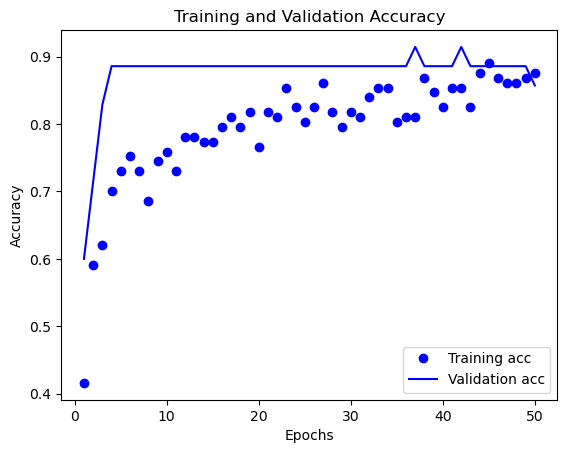

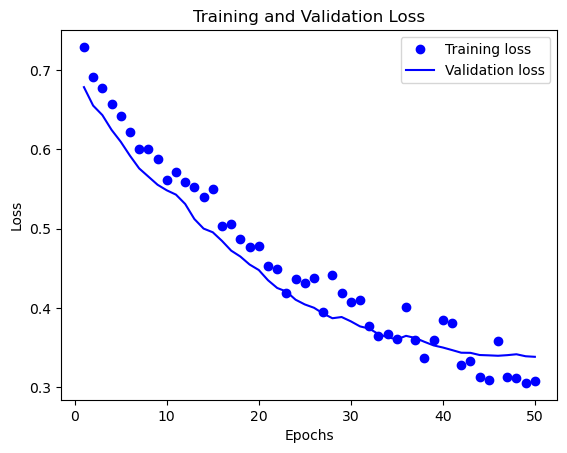

2/2 - 0s - loss: 0.3312 - accuracy: 0.8605 - 85ms/epoch - 42ms/step
Dropout test accuracy: 86.05%


In [19]:
# set random seeds
np.random.seed(462023)
tf.random.set_seed(4112023)

# dropout rate hyperparameter
RATE = 0.25

# define model architecture
model = models.Sequential([
    Dense(72, activation = 'relu', input_shape = (X_train.shape[1], )),
    Dropout(rate = RATE),
    Dense(36, activation = 'relu'),
    Dropout(rate = RATE),
    Dense(18, activation = 'relu'),
    Dropout(rate = RATE),
    Dense(2, activation = 'sigmoid')
])

# compile model
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# prepare response vectors
enc = OneHotEncoder()
y_trainDL = pd.DataFrame.sparse.from_spmatrix(enc.fit_transform(np.array(y_train).reshape(-1, 1)))
y_testDL = pd.DataFrame.sparse.from_spmatrix(enc.fit_transform(np.array(y_test).reshape(-1, 1)))

# number of epochs
EPOCHS = 50

# early stiopping criterion
early = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)

# train model
trained = model.fit(X_train, 
                    y_trainDL, 
                    epochs = EPOCHS, 
                    batch_size = 128,
                    validation_split = 0.2,
                    callbacks = early,
                    verbose = 0)

# prepare model evaluation
acc = trained.history['accuracy']
val_acc = trained.history['val_accuracy']
loss = trained.history['loss']
val_loss = trained.history['val_loss']
epochs = range(1, len(acc) + 1)

# plot training accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# predict on test set
test_loss, test_acc = model.evaluate(X_test, y_testDL, verbose = 2)
print(f"Dropout test accuracy: {round(test_acc * 100, 2)}%")